<a href="https://colab.research.google.com/github/Chaksome/Machine-Learning-Mnist/blob/main/myCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%%time
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

CPU times: user 23 µs, sys: 0 ns, total: 23 µs
Wall time: 28.1 µs


In [3]:
import numpy as np
import random
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
import matplotlib.pyplot as plt

!pip install tensorlayer
import tensorflow as tf
from tensorflow.python.framework import ops
from tensorflow.python.ops import math_ops
from tensorflow.python.training import moving_averages
import tensorlayer as tl
from tensorlayer import logging
from tensorlayer.layers.core import Layer

     |████████████████████████████████| 363 kB 16.0 MB/s 
     |████████████████████████████████| 3.3 MB 55.0 MB/s 
     |████████████████████████████████| 3.1 MB 46.7 MB/s 
  Attempting uninstall: pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2
  Attempting uninstall: imageio
    Found existing installation: imageio 2.4.1
    Uninstalling imageio-2.4.1:
      Successfully uninstalled imageio-2.4.1
  Attempting uninstall: progressbar2
    Found existing installation: progressbar2 3.38.0
    Uninstalling progressbar2-3.38.0:
      Successfully uninstalled progressbar2-3.38.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [4]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
#visulization
mu = 0
sigma = 10
#X_train = (X_train+np.random.normal(mu, sigma,size=X_train.shape))%255
#X_test = (X_test+np.random.normal(mu, sigma,size=X_test.shape))%255

11501568/11490434 [==============================] - 0s 0us/step


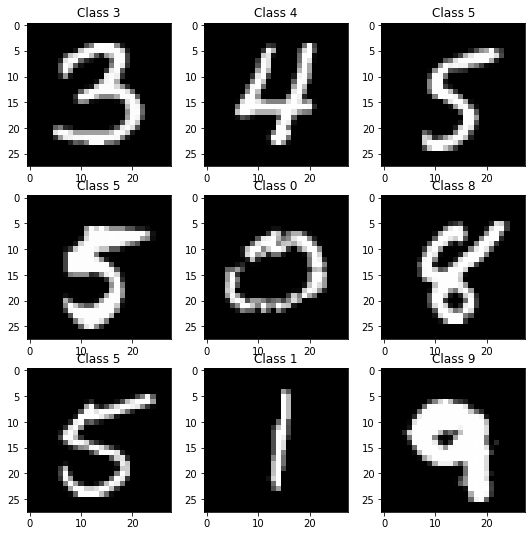

In [ ]:
plt.rcParams['figure.figsize'] = (9,9) # Make the figures a bit bigger

for i in range(9):
    plt.subplot(3,3,i+1)
    num = random.randint(0, len(X_train));
    plt.imshow(X_train[num], cmap='gray', interpolation='none')
    plt.title("Class {}".format(y_train[num]))

In [5]:
# input image dimensions
img_rows, img_cols = 28, 28
# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
pool_size = (2, 2)
# convolution kernel size
kernel_size = (3, 3)
batch_size = 128
nb_classes = 10
nb_epoch = 1

In [6]:
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols,1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols,1)
input_shape = (img_rows, img_cols,1)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.0
X_test /= 255.0
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

In [ ]:
#抗扭斜函数
from scipy.ndimage import interpolation

def moments(image):#计算图片的矩
    c0,c1 = np.mgrid[:image.shape[0],:image.shape[1]] 
    totalImage = np.sum(image) 
    m0 = np.sum(c0*image)/totalImage 
    m1 = np.sum(c1*image)/totalImage 
    m00 = np.sum((c0-m0)**2*image)/totalImage 
    m11 = np.sum((c1-m1)**2*image)/totalImage 
    m01 = np.sum((c0-m0)*(c1-m1)*image)/totalImage 
    mu_vector = np.array([m0,m1]) 
    covariance_matrix = np.array([[m00,m01],[m01,m11]]) 
    return mu_vector, covariance_matrix

def deskew(image):#根据计算结果旋转图片，抗扭斜
    c,v = moments(image)
    alpha = v[0,1]/v[0,0]
    affine = np.array([[1,0],[alpha,1]])
    ocenter = np.array(image.shape)/2.0
    offset = c-np.dot(affine,ocenter)
    return interpolation.affine_transform(image,affine,offset=offset)
def deskewAll(X):
    currents = []
    for i in range(len(X)):
        currents.append(deskew(X[i].reshape(28,28)))
    return np.array(currents)

In [33]:
#下面是对CNN的一些梳理及注解
import numpy as np
#先定义卷积层
class Conv2D(object):
    def __init__(self, in_channel, out_channel, kernel_size, lr=0.01, stride = 1, pad = 1, momentum=0.9, reg = 0.75, name='Conv'):
        self.w = np.random.randn(out_channel,in_channel, kernel_size, kernel_size)    #初始化权重，变量的初始值，来自于截取正态分布中的数据。
        self.b = np.random.randn(out_channel)#初始化偏置量
        w_shape = (out_channel,in_channel, kernel_size, kernel_size)#其中filter的结构为：[filter_height, filter_width, in_channels, out_channels]。
        self.layer_name = name
        self.lr = lr#定义学习率
        self.momentum = momentum
        self.stride = stride
        self.pad = pad
        self.reg = reg

        self.pre_gradient_w = np.zeros_like(self.w)#定义先前的权重梯度量
        self.pre_gradient_b = np.zeros_like(self.b)#定义先前的偏置梯度量
    #前馈网络
    def forward(self, in_data):
        self.out = None
        N, C, H, W = in_data.shape
        F, _, Hk, Wk = self.w.shape                                            #F是out_channel,HH是kernel_size,ww是kernel_size;
        stride, pad = self.stride, self.pad
        H_out = int(1 + (H + 2 * pad - Hk) / stride)                           #计算纵向卷积需要滑几步
        W_out = int(1 + (W + 2 * pad - Wk) / stride)                           #计算横向卷积需要滑几步
        self.out = np.zeros((N , F , H_out, W_out))

        in_data_pad = np.pad(in_data, ((0,), (0,), (pad,), (pad,)), mode='constant', constant_values=0) #边缘填充，这里上下左右各填一个像素"same"
        for i in range(H_out):
            for j in range(W_out):
                in_data_pad_masked = in_data_pad[:, :, i*stride:i*stride+Hk, j*stride:j*stride+Wk]
                for k in range(F):
                    self.out[:, k , i, j] = np.sum(in_data_pad_masked * self.w[k, :, :, :], axis=(1,2,3))+ self.b[k] #输出为权重乘原输入加偏置
        self.bottom_val = in_data#以输入值为底层值
        return self.out
#反向传播
    def backward(self, value):
        N, C, H, W = self.bottom_val.shape
        F, _, Hk, Wk = self.w.shape
        stride, pad = self.stride, self.pad
        H_out = int(1 + (H + 2 * pad - Hk) / stride)
        W_out = int(1 + (W + 2 * pad - Wk) / stride)

        x_pad = np.pad(self.bottom_val, ((0,), (0,), (pad,), (pad,)), mode='constant', constant_values=0)
        dx = np.zeros_like(self.bottom_val)
        dw = np.zeros_like(self.w)#定义权重偏导
        db = np.sum(value, axis=(0, 2, 3))#定义偏置偏导
        rot_w = np.rot90(self.w,2,(2,3))    #得到w的倒置矩阵，此处只交换2、3维 
        pad_diff_H = Hk - (1 + pad)
        pad_diff_W = Wk - (1 + pad)
        value_pad = np.pad(value, ((0,), (0,), (pad_diff_H,), (pad_diff_W,)), mode='constant', constant_values=0)  #数据填充
        
        for i in range(H_out):      # 计算dx，即对输入的偏导
            for j in range(W_out):
                value_pad_masked = value_pad[:, :, i*stride:i*stride+Hk, j*stride:j*stride+Wk]
                for h in range(C):
                    dx[:, h , i, j] = np.sum(value_pad_masked[:,:,:,:] * rot_w[:, h, :, :], axis=(1,2,3))    
        
        for m in range(HH):         #计算dw，即权重偏导
            for n in range(WW):
                x_pad_masked_d = x_pad[:, :, m * stride:m * stride + H_out, n * stride:n * stride + W_out]
                for k in range(F):
                    for p in range(C):
                        dw[k, p, m, n] = np.sum(x_pad_masked_d[:,p,:,:] * value[:, k, :, :], axis=(0,1,2)) 
        self.w -= self.lr * (dw + self.prev_gradient_w * self.reg)#根据学习率更新权重
        self.b -= self.lr * db#根据学习率更新偏置
        self.pre_gradient_w = self.w#循环
        return dx
#定义激活函数层，在keras中该层并不单独成层
class ReLU:
    def __init__(self, name='ReLU'):
        pass
    def forward(self, in_data):
        in_data[in_data<0] = 0 #小于0的都变成0
        self.top_val = in_data
        return in_data
    def backward(self, value):
        return (self.top_val > 0) * value # 此处为relu激活函数



#定义池化层
class MaxPooling:
    def __init__(self, kernel_size, stride = 1, name='MaxPool'):
        self.kernel_size = kernel_size#定义核大小
        self.stride = stride#定义stride
    def forward(self, in_data):
        self.bottom_val = in_data#以输入值为底层值
        N, C, H, W = in_data.shape#默认NHWC，表示4维数据，[batch,height,width,channels].
        Hk, Wk, stride = self.kernel_size, self.kernel_size, self.stride       #正方kernel
        H_out = int((H - Hk) / stride + 1)                                     #计算纵向需要滑行步数
        W_out = int((W - Wk) / stride + 1)                                     #计算横向需要滑行步数
        out = np.zeros((N, C, H_out, W_out))  #得到输出值的尺寸为(N, C, H_out, W_out)
        for i in range(H_out):
            for j in range(W_out):
                x_masked = in_data[:, :, i * stride: i * stride + HH, j * stride: j * stride + WW]
                out[:, :, i, j] = np.max(x_masked, axis=(2, 3))#最大值池化
        return out#输出池化结果
    def backward(self, value):
        N, C, H, W = self.bottom_val.shape
        Hk, Wk, stride = self.kernel_size, self.kernel_size, self.stride
        H_out = int((H - Hk) / stride + 1)                                     #计算纵向需要滑行步数
        W_out = int((W - Wk) / stride + 1)                                     #计算横向需要滑行步数
        dx = np.zeros_like(self.bottom_val)

        for i in range(H_out):
            for j in range(W_out):
                x_masked = self.bottom_val[:, :, i * stride: i * stride + HH, j * stride: j * stride + WW]
                max_x_masked = np.max(x_masked, axis=(2, 3))
                temp_binary_mask = (x_masked == (max_x_masked)[:, :, None, None])#寻找最大值对应的位置
                dx[:, :, i * stride: i * stride + HH, j * stride: j * stride + WW] += temp_binary_mask * (value[:, :, i,j])[:, :,None, None]#求局域偏导
        return dx#上采样返回局域偏导

#定义全连接层
class Flatten:
    def __init__(self, name='Flatten'):
        pass
    def forward(self, in_data):
        self.in_batch, self.in_channel, self.height, self.length = in_data.shape#记录数据的shape
        return in_data.reshape(self.in_batch, self.in_channel * self.height * self.length)#reshape成一维长链，全连接且总数相同   
    def backward(self, residual):
        return residual.reshape(self.in_batch, self.in_channel, self.height, self.length)#reshape成一维长链,全连接且总数相同   

#定义输出层
class Softmax:
    def __init__(self, name='Softmax'):
        pass
    def forward(self, in_data):
        shift_scores = in_data - np.max(in_data, axis=1).reshape(-1, 1)#在该行中找到最大的数字，每行中10个数都减去这个数
        self.top_val = np.exp(shift_scores) / np.sum(np.exp(shift_scores), axis=1).reshape(-1, 1)#reshape成(none,1)
        return self.top_val#输出最高层值
    def backward(self, value):
        N = value.shape[0]
        d_scores = self.top_val.copy()
        d_scores[range(N), list(value)] -= 1   #loss对softmax层的求导
        d_scores /= N
        return d_scores#返回梯度下降后的值偏导

In [18]:
#最终模型如下所示，为方便优化，都基于Keras编程
model = Sequential()
input_shape = X_train.shape[1:]
model.add(layers.Conv2D(28,kernel_size=3,activation='relu',input_shape=input_shape))#28C3S1的卷积层，输出为（None,26,26,28）
model.add(layers.BatchNormalization())#BN归一化，其作用在整个batch上，沿着C维度对N,H,W三个维度进行归一化
model.add(layers.Conv2D(28,kernel_size=3,activation='relu'))#28C3S1的卷积层，输出为（None,24,24,28）
model.add(layers.BatchNormalization())#BN归一化，其作用在整个batch上，沿着C维度对N,H,W三个维度进行归一化
model.add(layers.Conv2D(28,kernel_size=5,strides=2,padding='same',activation='relu'))#28C5S2的卷积层，输出为（None,12,12,28）
model.add(layers.BatchNormalization())#BN归一化，其作用在整个batch上，沿着C维度对N,H,W三个维度进行归一化
model.add(layers.Dropout(0.4))#随机失活0.4

model.add(layers.Conv2D(56,kernel_size=3,activation='relu'))#56C3S1的卷积层，输出为（None,10,10,56）
model.add(layers.BatchNormalization())#BN归一化，其作用在整个batch上，沿着C维度对N,H,W三个维度进行归一化
model.add(layers.Conv2D(56,kernel_size=3,activation='relu'))#56C3S1的卷积层，输出为（None,8,8,56）
model.add(layers.BatchNormalization())#BN归一化，其作用在整个batch上，沿着C维度对N,H,W三个维度进行归一化
model.add(layers.Conv2D(56,kernel_size=5,strides=2,padding='same',activation='relu'))#56C5S2的卷积层，输出为（None,4,4,56）
model.add(layers.BatchNormalization())#BN归一化，其作用在整个batch上，沿着C维度对N,H,W三个维度进行归一化
model.add(layers.Dropout(0.4))#随机失活0.4

model.add(layers.Flatten())#压缩，全连接层
model.add(layers.Dense(256, activation='relu'))#隐藏全连接层，激活函数相同
model.add(layers.BatchNormalization())#BN归一化，其作用在整个batch上，沿着C维度对N,H,W三个维度进行归一化
model.add(layers.Dropout(0.4))
model.add(layers.Dense(10, activation='softmax'))#输出层
model.summary()
model.compile(loss="categorical_crossentropy", metrics=["accuracy"])#误差函数选择"categorical_crossentropy"

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 26, 26, 28)        280       
                                                                 
 batch_normalization_14 (Bat  (None, 26, 26, 28)       112       
 chNormalization)                                                
                                                                 
 conv2d_13 (Conv2D)          (None, 24, 24, 28)        7084      
                                                                 
 batch_normalization_15 (Bat  (None, 24, 24, 28)       112       
 chNormalization)                                                
                                                                 
 conv2d_14 (Conv2D)          (None, 12, 12, 28)        19628     
                                                                 
 batch_normalization_16 (Bat  (None, 12, 12, 28)      

In [ ]:
!pip install -q -U tensorflow-addons

     |████████████████████████████████| 1.1 MB 5.1 MB/s 


In [16]:
#将BN改为GN试一试（其实效果并不好）
import tensorflow_addons as tfa
model = Sequential()
input_shape = X_train.shape[1:]
model.add(layers.Conv2D(28,kernel_size=3,activation='relu',input_shape=input_shape))
model.add(tfa.layers.GroupNormalization(groups=4, axis=3))
model.add(layers.Conv2D(28,kernel_size=3,activation='relu'))
model.add(tfa.layers.GroupNormalization(groups=4, axis=3))
model.add(layers.Conv2D(28,kernel_size=5,strides=2,padding='same',activation='relu'))
model.add(tfa.layers.GroupNormalization(groups=4, axis=3))
model.add(layers.Dropout(0.4))

model.add(layers.Conv2D(56,kernel_size=3,activation='relu'))
model.add(tfa.layers.GroupNormalization(groups=4, axis=3))
model.add(layers.Conv2D(56,kernel_size=3,activation='relu'))
model.add(tfa.layers.GroupNormalization(groups=4, axis=3))
model.add(layers.Conv2D(56,kernel_size=5,strides=2,padding='same',activation='relu'))
model.add(tfa.layers.GroupNormalization(groups=4, axis=3))
model.add(layers.Dropout(0.4))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(tfa.layers.GroupNormalization(groups=4, axis=3))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(10, activation='softmax'))

model.compile(loss="categorical_crossentropy", metrics=["accuracy"])

ModuleNotFoundError: ignored

Epoch 1/100
468/468 [==============================] - 276s 457ms/step - loss: 0.2183 - accuracy: 0.9330 - val_loss: 0.1898 - val_accuracy: 0.9393 - lr: 0.0010
Epoch 2/100
468/468 [==============================] - 214s 457ms/step - loss: 0.0750 - accuracy: 0.9761 - val_loss: 0.0244 - val_accuracy: 0.9923 - lr: 9.5000e-04
Epoch 3/100
468/468 [==============================] - 215s 459ms/step - loss: 0.0580 - accuracy: 0.9829 - val_loss: 0.0261 - val_accuracy: 0.9923 - lr: 9.0250e-04
Epoch 4/100
468/468 [==============================] - 215s 459ms/step - loss: 0.0457 - accuracy: 0.9855 - val_loss: 0.0196 - val_accuracy: 0.9938 - lr: 8.5737e-04
Epoch 5/100
468/468 [==============================] - 214s 458ms/step - loss: 0.0400 - accuracy: 0.9877 - val_loss: 0.0173 - val_accuracy: 0.9945 - lr: 8.1451e-04
Epoch 6/100
468/468 [==============================] - 215s 458ms/step - loss: 0.0380 - accuracy: 0.9886 - val_loss: 0.0209 - val_accuracy: 0.9936 - lr: 7.7378e-04
Epoch 7/100
468/468 

Text(0, 0.5, 'Accuracy')

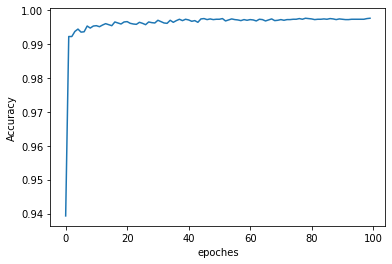

In [19]:
#带数据增强测试
import matplotlib.pyplot as plt
from keras.callbacks import LearningRateScheduler
annealer = LearningRateScheduler(lambda x: 1*1e-3 * 0.95 ** (x), verbose=0)
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        rotation_range=15,  #旋转
        zoom_range = 0.1, #缩放
        shear_range=0.1, #剪切
      
        width_shift_range=0.0, 
        height_shift_range=0.00)#鉴于mnist图像都较为正中间，不设平移
history = model.fit(datagen.flow(X_train,Y_train, batch_size=batch_size), epochs = 100, steps_per_epoch = X_train.shape[0]//batch_size,
                              validation_data = (X_test,Y_test), callbacks=[annealer], verbose=1)
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoches')
plt.ylabel('Accuracy')

In [21]:
#可视化错误图片
prediction = np.round(model.predict(X_test))
predictions = np.argmax(prediction, axis=1)
wrong_predictions = (X_test[predictions != y_test]*255.0)[:,:,:,0]
wrong_label = predictions[predictions != y_test]
right_label = y_test[predictions != y_test]

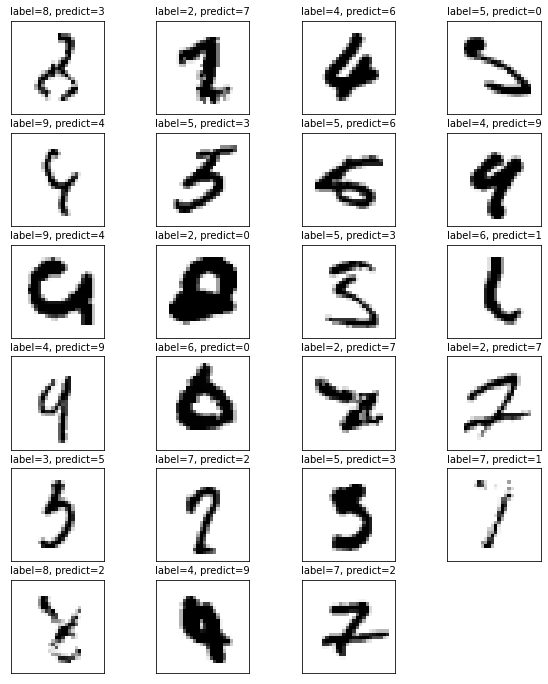

In [22]:

# 定义可视化函数
def plot_images_labels_prediction(images, labels, prediction, index, num=10):  
      fig = plt.gcf()   # 加载当前图片集
      fig.set_size_inches(10, 12)  # 显示成英寸形式
      for i in range(0, num):
            ax = plt.subplot(6, 4, i+1)  # 画多个子图
            ax.imshow(np.reshape(images[index], (28, 28)), cmap='binary')  # 显示第index张图像
            title = "label=" + str(labels[index])   # 显示的title为预测结果与实际结果
            if len(prediction) > 0:
                  title += ", predict=" + str(prediction[index])
            ax.set_title(title, fontsize=10)
            ax.set_xticks([])  # 不显示坐标轴
            ax.set_yticks([])
            index += 1
      plt.show()
# 显示全部错误图像
plot_images_labels_prediction(wrong_predictions, right_label, wrong_label, 0, 23)

In [20]:
#储存最优模型
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive')
!mkdir -p saved_model
model.save('saved_model/my_model')
model.summary()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
INFO:tensorflow:Assets written to: saved_model/my_model/assets
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 26, 26, 28)        280       
                                                                 
 batch_normalization_14 (Bat  (None, 26, 26, 28)       112       
 chNormalization)                                                
                                                                 
 conv2d_13 (Conv2D)          (None, 24, 24, 28)        7084      
                                                                 
 batch_normalization_15 (Bat  (None, 24, 24, 28)       112       
 chNormalization)                                                
                                                            